In [1]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
import anndata as ad
import csv
import gpzoo.pri_experiment_utilities as putil
import matplotlib.pyplot as plt
import numpy as np
import random
import scanpy as sc
import scipy.sparse as sparse
import squidpy as sq
import tensorflow as tf
import time
import torch
import torch.nn.utils as nn_utils

from anndata import AnnData
from contextlib import suppress
from copy import deepcopy
from gpzoo.gp import SVGP
from gpzoo.kernels import NSF_RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import (add_jitter, anndata_to_train_val, deviancePoisson, 
                       
dims_autocorr, regularized_nmf, rescale_spatial_coords, 
                             scanpy_sizefactors)
from os import path
from scanpy import read_h5ad
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.model_selection import ParameterGrid, KFold, train_test_split
from sklearn.metrics import mean_poisson_deviance, root_mean_squared_error
from sklearn.linear_model import PoissonRegressor
from squidpy.gr import spatial_autocorr, spatial_neighbors
from tensorflow import constant
from tensorflow.data import Dataset
from torch import distributions, nn, optim
from tqdm.auto import tqdm
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from sklearn.utils import resample

In [3]:
print("CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available:  True
Number of GPUs:  2
Current GPU:  0
GPU Name:  NVIDIA A30


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
random.seed(256)
root_path = '/engelhardt/home/pshrestha/vnngp/'
save_path = path.join(root_path, 'results/visium/nnnsf')

In [6]:
save_path

'/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf'

In [7]:
X, Y = putil.load_visium()

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, Y.T, test_size=0.05, random_state=256)

In [18]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(2553, 2)
(135, 2)
(2553, 11925)
(135, 11925)


<Axes: >

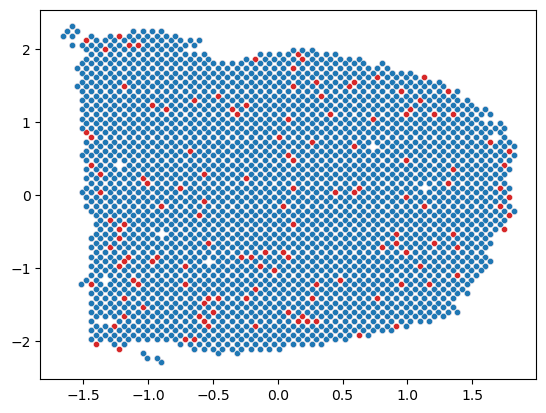

In [19]:
sns.scatterplot(X=X, Y=Y)
sns.scatterplot(x=X[:,0],y=X[:,1],marker="o",s=20, color='tab:red')
sns.scatterplot(x=X_train[:,0],y=X_train[:,1],marker="o",s=20, color='tab:blue')

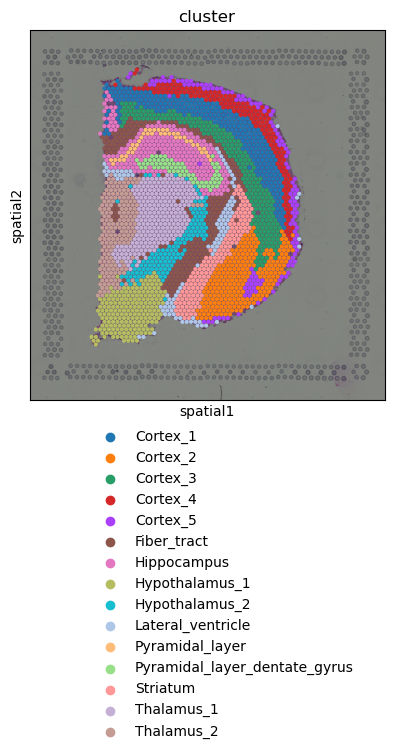

In [20]:
ad = sq.datasets.visium_hne_adata()
ad.var["mt"] = ad.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
Y_sums = np.array(np.sum(ad.raw.X > 0, axis=0))[0]
    
Y = np.array(ad.raw.X[:, Y_sums>200].todense(), dtype=int).T
X = ad.obsm['spatial']
X = X.astype('float64')
Y = Y.astype('float64')
X = rescale_spatial_coords(X)
fig, axes = plt.subplots()
sq.pl.spatial_scatter(ad, color="cluster", size=1.5, ax=axes)
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.55, -0.95), frameon=False)

In [21]:
# Define the size of the regions
region_size = 1.7
#np.random.seed(0)

# Define the valid range for the lower bounds
x_range = (X[:,0].min(), X[:,0].max() - region_size)
y_range = (X[:,1].min(), X[:,1].max() - region_size)

# Function to select a random region
def select_random_region(x_range, y_range, region_size):
    # Adjust ranges to ensure the square fits within the bounds
    x_min = random.uniform(x_range[0], x_range[1] - region_size)
    y_min = random.uniform(y_range[0], y_range[1] - region_size)
    
    x_max = x_min + region_size
    y_max = y_min + region_size
    
    return x_min, x_max, y_min, y_max


def select_non_overlapping_regions(x_range, y_range, region_size, num_regions):
    # Calculate the number of possible squares along each axis
    x_steps = int((x_range[1] - x_range[0]) // region_size)
    y_steps = int((y_range[1] - y_range[0]) // region_size)
    
    # Create a grid of possible top-left corners
    possible_positions = [(x_range[0] + i * region_size, y_range[0] + j * region_size)
                          for i in range(x_steps) for j in range(y_steps)]
    
    # Randomly select positions for the regions without replacement to avoid overlap
    selected_positions = random.sample(possible_positions, num_regions)
    
    # Generate the regions
    regions = [(x_min, x_min + region_size, y_min, y_min + region_size) for (x_min, y_min) in selected_positions]
    
    return regions


np.random.seed(0) #254
regions = []
for _ in range(1):
    x_min, x_max, y_min, y_max = select_random_region(x_range, y_range, region_size)
    regions.append((x_min, x_max, y_min, y_max))

#regions = select_non_overlapping_regions(x_range, y_range, region_size, 5)

In [22]:
#regions = [(0.028917443830650313, 1.5289174438306503, -0.06656527168498672, 1.4334347283150133),
              #(-1.2996974976339435, 0.2003025023660565, -1.42920866833921121, 0.0079133166078879)]

In [23]:
#regions = [ (0.030083602561433498, 0.7300836025614335, 0.492930877332324, 1.192930877332324), 
          # (-0.4778506944950651, 0.22214930550493484, -1.101786115114805309, -0.4282138848851946),
           #(-0.6590241627691157, 0.04097583723088427, -1.952626897827451, -1.252626897827451)]

In [24]:
regions = [(-0.6590241627691157, 0.04097583723088427, -1.952626897827451, -1.252626897827451)]

(104, 2)
Region 1: x_min=-0.6590241627691157, x_max=0.04097583723088427, y_min=-1.952626897827451, y_max=-1.252626897827451


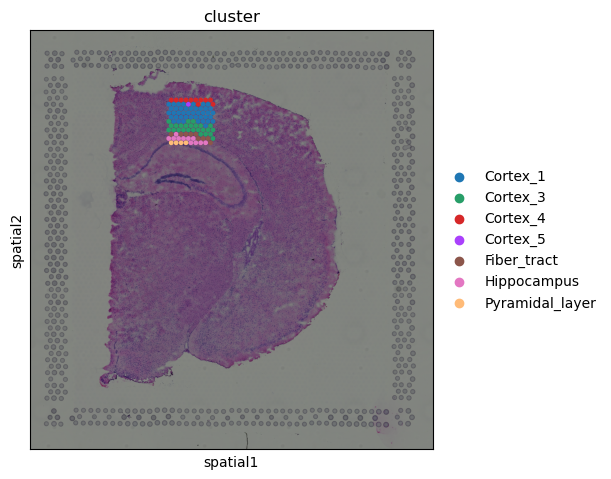

In [35]:
# Filter and plot each region
experiment_indices = []
for i, (x_min, x_max, y_min, y_max) in enumerate(regions):
    indices = np.where((X[:, 0] >= x_min) & (X[:, 0] <= x_max) & (X[:, 1] >= y_min) & (X[:, 1] <= y_max))[0]
    X_square = X[indices]
    Y_square = Y[:, indices]
    print(X_square.shape)
    experiment_indices.append(indices)
    # Visualize each selected square (if desired)
    print(f"Region {i+1}: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")
    sq.pl.spatial_scatter(ad[indices], color="cluster", size=1.5, figsize=(6,6))

104


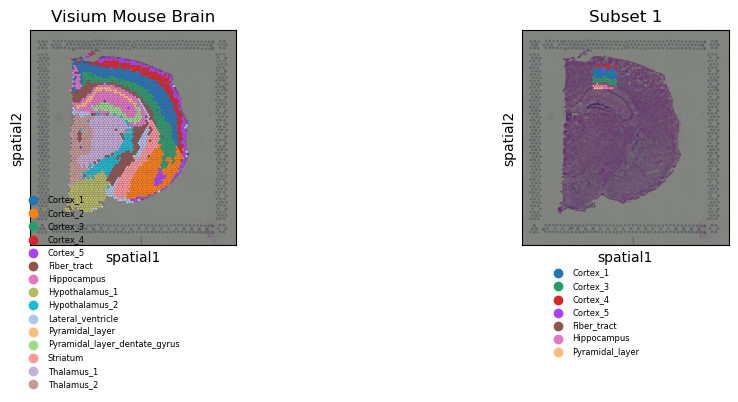

In [26]:
# Create a figure with subplots
fig, axes = plt.subplots(1, len(regions) + 1, figsize=(10, 5))  # len(regions) + 1 to include the original plot

# Original plot
sq.pl.spatial_scatter(ad, color="cluster", size=1.5, ax=axes[0])
axes[0].set_title("Visium Mouse Brain")
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(0.35, -0.7), frameon=False, fontsize=6)

# Plot each region side by side
for i, (x_min, x_max, y_min, y_max) in enumerate(regions):
    indices = np.where((X[:, 0] >= x_min) & (X[:, 0] <= x_max) & (X[:, 1] >= y_min) & (X[:, 1] <= y_max))[0]
    X_square = X[indices]
    Y_square = Y[:, indices]
    print(len(X_square))
    
    # Plot each selected square
    sq.pl.spatial_scatter(ad[indices], color="cluster", size=1.5, ax=axes[i+1])
    axes[i+1].set_title(f"Subset {i+1}")#\n(x: {x_min:.2f}-{x_max:.2f}, y: {y_min:.2f}-{y_max:.2f})")
    handles, labels = axes[i+1].get_legend_handles_labels()
    axes[i+1].legend(handles, labels, loc='lower center', bbox_to_anchor=(0.35, -0.55), frameon=False, fontsize=6)

plt.tight_layout()
save_path = '/engelhardt/home/pshrestha/vnngp/results/visium/plots'
#fig.savefig(f'{save_path}/visium_k_subset_visual.png')
plt.show()

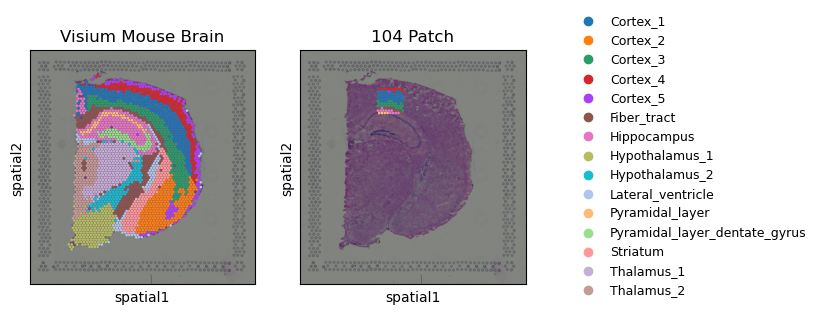

In [27]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2)  # len(regions) + 1 to include the original plot

# Original plot
sq.pl.spatial_scatter(ad, color="cluster", size=1.5, ax=axes[0])
axes[0].set_title("Visium Mouse Brain")
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower left', bbox_to_anchor=(2.37, -0.1), frameon=False, fontsize=9)


# Plot each region side by side
for i, (x_min, x_max, y_min, y_max) in enumerate(regions):
    indices = np.where((X[:, 0] >= x_min) & (X[:, 0] <= x_max) & (X[:, 1] >= y_min) & (X[:, 1] <= y_max))[0]
    X_square = X[indices]
    Y_square = Y[:, indices]
    
    # Plot each selected square
    sq.pl.spatial_scatter(ad[indices], color="cluster", size=1.5, ax=axes[1], legend_loc=False)
    axes[1].set_title(f"104 Patch")#\n(x: {x_min:.2f}-{x_max:.2f}, y: {y_min:.2f}-{y_max:.2f})")

#axes[1].text(x=440, y=590, s="1", color='white', fontsize=12, weight='bold')
#axes[1].text(x=870, y=1030, s="2", color='white', fontsize=12, weight='bold')
#axes[1].text(x=520, y=670, s="4", color='white', fontsize=12, weight='bold')
#axes[1].text(x=870, y=910, s="3", color='white', fontsize=12, weight='bold')
#axes[1].text(x=960, y=490, s="5", color='white', fontsize=12, weight='bold')

plt.tight_layout()
save_path = '/engelhardt/home/pshrestha/vnngp/results/visium/plots'
fig.savefig(f'{save_path}/visium_k_subset_visual_condensed.png', bbox_inches='tight')
plt.show()

### NMF Initialization

In [16]:
nmf_model = NMF(n_components=15, max_iter=1000, init='random', random_state=256, alpha_H=2e-1, alpha_W=1e-7)

In [211]:
nmf_model.fit(Y)
print(Y.shape)

(2688, 11925)


In [18]:
exp_factors = nmf_model.transform(Y)
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T

In [22]:
loadings.shape

(11925, 15)

In [21]:
nmf_save_path = path.join(root_path, 'results/visium/nmf/')
factors_path = path.join(nmf_save_path, 'nmf_factors_iter=1000_rs=256_L=15.npy')
loadings_path = path.join(nmf_save_path, 'nmf_loadings_iter=1000_rs=256_L=15.npy')
np.save(factors_path, factors)
np.save(loadings_path, loadings)

In [216]:
moran_idx, moranI = putil.dims_autocorr(np.exp(factors), X)

In [218]:
print(factors.shape)
print(X.shape)

(2688, 5)
(2688, 2)


In [ ]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

In [ ]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    print(factors.shape)
    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)


    if ax is None:
        fig, ax = plt.subplots(L//5, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):

        curr_ax = ax[i//5, i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
            
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

    return fig

In [ ]:
factors_ordered.shape

In [10]:
#size=2
#fig, axes = plt.subplots(2, 5, figsize=(size*5, size*1), tight_layout=True)
fig = plot_factors(np.exp(factors_ordered).T, X, moran_idx=moran_idx, size=2, s=2.0, alpha=1.0)
fig.suptitle("NMF Initialization")
fig.set_figheight(6)
#fig.savefig(f"{save_path}_L=15_nmf_initialization.png")

NameError: name 'plot_factors' is not defined

### Experiments

In [10]:
def validation_step(model, X_val, y_val, E=10, **kwargs):
    '''
    Compute the validation Poisson deviance on held-out data.

    Parameters:
    - model: model instance
    - X_val: Validation data features
    - y_val: Validation data targets (counts)
    - E: number of samples for Monte Carlo estimation

    Returns:
    - Poisson deviance between observed and predicted counts on validation data.
    '''

    pY_val, _, _, _ = model.forward(X=X_val, E=E, **kwargs)
    if pY_val.mean:
        y_pred = pY_val.mean
    else:
        y_pred = pY_val.sf.mean # hybrid
    
    deviance = mean_poisson_deviance(y_val.flatten().numpy(), y_pred.flatten().detach().numpy())
    
    return deciance

In [11]:
def predict(self, X_train, y_train, X_val=None, E=10):
    """
    Predict mean counts for training and validation data.

    Parameters:
    - self: An instance of NSF2.
    - X_train: Training data features.
    - y_train: Training data targets (counts).
    - X_val: Validation data features (optional).
    - E: Number of samples for predictive mean.

    Returns:
    - Predicted means for training and (optionally) validation data.
    """
    pY_train, _, _, _ = self.forward(X=X_train, E=E, **kwargs)
    if X_val is not None:
        pY_val, _, _, _ = self.forward(X=X_val, E=E, **kwargs)
        Mu_val = pY_val.mean
    else:
        Mu_val = None
    return Mu_tr, Mu_val

In [10]:
factors = np.load(path.join(root_path,'results/visium/nmf/nmf_factors_iter=1000_rs=256_L=5.npy'))
lodaings = np.load(path.join(root_path,'results/visium/nmf/nmf_loadings_iter=1000_rs=256_L=5.npy'))

In [11]:
headers = ['iterations', 'learning_rate', 'sigma', 'lengthscale', 'time', 'K', 'rmse_loss']

In [12]:
csv_path = path.join(save_path, 'visium_nsf_csv_results.csv')

In [13]:
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [104]:
def run_experiment(X, Y, save_path, NMF=True, batched=True):
    # Define the parameter grid
    param_grid = {
        'sigma': [1.0],
        'lengthscale': [1.0],
        'learning_rate': [1e-3],
        'iterations': [10*1000],
        'L': [5],
        'K': [4]
    }
   
                
    #with open(csv_path, mode='a', newline='') as file:
        #writer = csv.writer(file)
    
    # Iterate over each parameter combination
    for params in ParameterGrid(param_grid):
        final_time = 0.0
        dicts = {
                    'L': params['L'], 
                    'M': len(X), # use total number of inducing points
                    'sigma': params['sigma'], 
                    'lengthscale': params['lengthscale'], 
                    'jtr': 1e-1, # no lower
                    'batch_size': 128,
                    'lr': params['learning_rate'],
                    'rs': 256,
                    'lkzz_build': 1,
                    'model': 'VNNGP',
                    'L1_jitter': 1e-1, # no lower
                    'iterations': params['iterations'],
                    'K': params['K'],
            }
        kwargs = dicts
        
        # load in factors and loadings
        nmf_save_path = path.join(root_path, 'results/visium/nmf/')
        factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={kwargs['L']}.npy")
        loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={kwargs['L']}.npy")
        factors = np.load(factors_path)
        loadings = np.load(loadings_path)
    
    
        file_path = kwargs['model']
        if kwargs['model'] == 'VNNGP':
            file_path += f"_K={kwargs['K']}"
            if kwargs['lkzz_build']:
                file_path += f"_lkzz={kwargs['lkzz_build']}"
        file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_ls={kwargs['lengthscale']}_sigma={kwargs['sigma']}"

        X_array = None
        Y_array = None
            
        if batched:
            file_path += f"_bs={kwargs['batch_size']}"
            
        if NMF:
            file_path += f"_NMFinit"
            X_array = np.array(X)
            Y_array = np.array(Y)
            moran_idx, moranI = putil.dims_autocorr(factors, X_array)
            factors = factors[:, moran_idx]
            loadings = loadings[:, moran_idx]

        # check of model and its state dictionary already exist
        model_state_path = f'{save_path}/{file_path}_state_dict.pth'
        model_info_path = f'{save_path}/{file_path}_model.pt'

        '''
        if path.exists(model_state_path) and path.exists(model_info_path):
            print(f"Loading existing model from {model_state_path} and continuing training.")
            model = putil.build_model(X_array, Y_array, loadings=loadings, factors=factors, kwargs=kwargs)
            model.load_state_dict(torch.load(model_state_path))
                
            saved_info = torch.load(model_info_path)
            losses = saved_info.get('losses', [])
            means = saved_info.get('means', [])
            scales = saved_info.get('scales', [])
            final_time = saved_info.get('time', 0)
        else:
            print(f"Training a new model and saving to {model_state_path}.")
        '''
        model = putil.build_model(X_array, Y_array, loadings=loadings, factors=factors, **kwargs)
        losses, means, scales, final_time = [], [], [], 0
        

        putil.model_grads(model)
        model.prior.jitter = kwargs['jtr']
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
        model.to(device)
        X_torch = torch.tensor(X).type(torch.float).to(device)
        Y_torch = torch.tensor(Y).type(torch.float).to(device)
    
        start_time = time.time()
        more_losses, more_means, more_scales, idxs = putil.train_batched(model, optimizer, X_torch, Y_torch, device, 
                                                                         steps=kwargs['iterations'], E=3, kwargs=kwargs)
        end_time = time.time()
        final_time += (end_time - start_time)

        # combine new and previous losses, means, scales
        losses.extend(more_losses)
        means.extend(more_means)
        scales.extend(more_scales)

        #torch.save(model.state_dict(), model_state_path)
        #torch.save({
                #'losses': losses,
                #'means': means,
                #'scales': scales,
                #'time': final_time
        #}, model_info_path)
    
        with torch.no_grad():
            X_torch = torch.tensor(X).type(torch.float)
            Y_torch = torch.tensor(Y).type(torch.float)
            val_loss = putil.evaluate_model(model, X_torch.cpu(), Y_torch, device, kwargs=kwargs)
            
        mean_cv_loss = np.mean(val_loss)
        print(f'Params: {params}, Mean CV Loss: {mean_cv_loss}')
    
        #write the results to the CSV file
        #writer.writerow([params['iterations'], params['learning_rate'], params['sigma'], params['lengthscale'], final_time,  params['K'], mean_cv_loss])
    
        fig1, ax1 = plt.subplots()
        ax1.plot(losses)
        fig1.suptitle(f"{kwargs['model']} Loss | sigma: {params['sigma']}, lengthscale: {params['lengthscale']}")
        #fig1.savefig(f'{save_path}/{file_path}_loss.png')
        plt.show()
        #plt.close()
    
        model.cpu()
        X_torch = torch.tensor(X).type(torch.float)
        qF, _, _ = model.prior(X_torch.cpu(), kwargs=kwargs)
        mean = torch.exp(qF.mean).detach().numpy()
        if kwargs['L'] == 5:
            fig2 = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1, alpha=1, ax=None)
        else:
            fig2 = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1, alpha=1, ax=None)
        fig2.suptitle("Visium NNNSF", size=15)
        fig2.set_figheight(2.25)
        fig2.tight_layout()
        #fig2.savefig(f'{save_path}/{file_path}_plot.png')
        plt.show()
        #plt.close()
        model.to(device)
        torch.cuda.empty_cache()
        return model

In [60]:
dicts = {
    'L': 5, 
    'M': len(X), # use total number of inducing points
    'sigma': 0.1, 
    'lengthscale': 0.07, 
    'jtr': 1e-1, # no lower
    'batch_size': 128,
    'lr': 1e-3,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter': 1e-1, # no lower
    'iterations':5000,
    'K': 4,}

  0%|          | 0/10000 [00:00<?, ?it/s]

Params: {'K': 4, 'L': 5, 'iterations': 10000, 'learning_rate': 0.001, 'lengthscale': 1.0, 'sigma': 1.0}, Mean CV Loss: 10.24718189239502


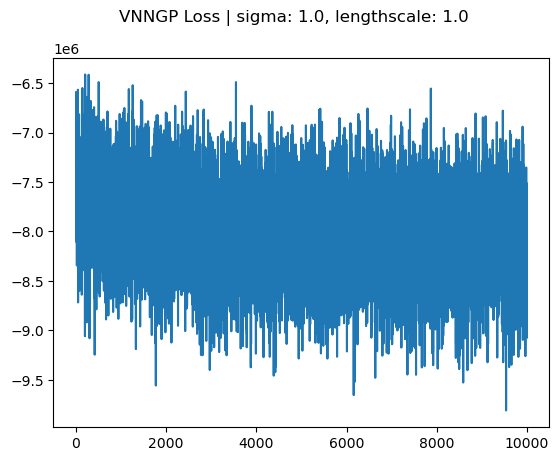

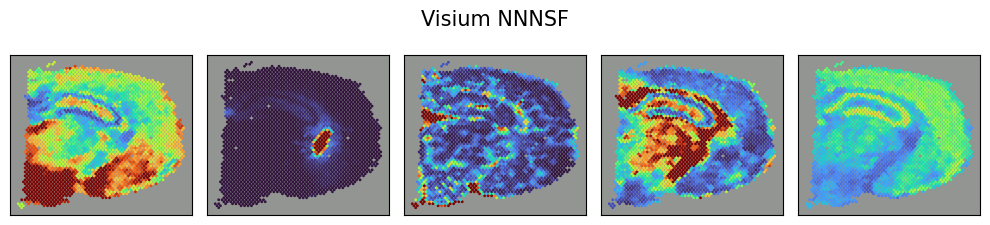

In [105]:
model = run_experiment(X, Y.T, save_path)

In [106]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
model.to(device)
X_torch = torch.tensor(X).type(torch.float).to(device)
Y_torch = torch.tensor(Y).type(torch.float).to(device)

In [107]:
more_losses, more_means, more_scales, idxs = putil.train_batched(model, optimizer, X_torch, Y_torch.T, device, 
                                                                         steps=10*1000, E=3, kwargs=dicts)

  0%|          | 0/10000 [00:00<?, ?it/s]

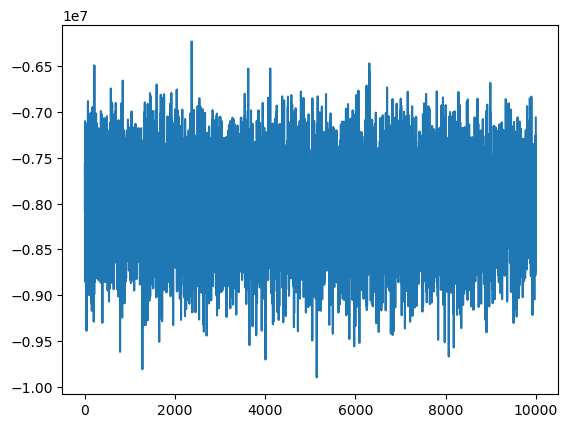

In [108]:
plt.plot(more_losses)

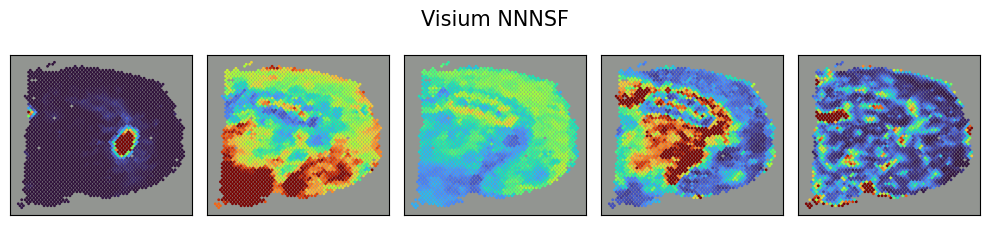

In [109]:
model.cpu()
X_torch = torch.tensor(X).type(torch.float)
qF, _, _ = model.prior(X_torch.cpu(), kwargs=dicts)
mean = torch.exp(qF.mean).detach().numpy()
if dicts['L'] == 5:
    fig2 = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2 = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
fig2.suptitle("Visium NNNSF", size=15)
fig2.set_figheight(2.25)
fig2.tight_layout()

In [92]:
X_train = torch.tensor(X_train).type(torch.float)
X_val = torch.tensor(X_val).type(torch.float)

In [95]:
Mu, Mu_val = model.predict(X_train.cpu(), X_val.cpu(), kwargs=dicts)

In [96]:
train_loss = putil.evaluate_model(model, X_train.cpu(), y_train.T, device, kwargs=dicts)

In [97]:
val_loss = putil.evaluate_model(model, X_val.cpu(), y_val.T, device, kwargs=dicts)

In [98]:
print(f"Train loss is {train_loss} and val loss is {val_loss}")

Train loss is 10.267297637235334 and val loss is 10.54363430571674


In [99]:
train_loss = putil.evaluate_model(model, X_train.cpu(), y_train.T, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

In [100]:
train_loss

1.918765293267356

In [101]:
val_loss = putil.evaluate_model(model, X_val.cpu(), y_val.T, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

In [102]:
val_loss

2.0043763187376826

In [25]:
qF, _, _ = model.prior(X_train.to(device), kwargs=dicts)

In [26]:
qF.mean.shape

torch.Size([5, 2553])

In [27]:
X_train.shape

torch.Size([2553, 2])

In [29]:
Y.shape

(2688, 11925)

In [ ]:
size=2
fig, axes = plt.subplots(3, 5, figsize=(size*5, size*3), tight_layout=True)
fig = plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1, alpha=1, ax=axes)
fig.suptitle("Visium NSF", size=15)
#fig.set_figheight(4.25)
fig.tight_layout()
plt.show()

In [ ]:
model.cpu()
qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()

In [ ]:
fig = plot_factors(mean, X.cpu().detach().numpy(), moran_idx=None, size=2, s=5, alpha=1, ax=None)
fig.suptitle("GGblocks NSF", size=15)
fig.set_figheight(4.25)
fig.tight_layout()
plt.show()

### Subset K Experiments

In [28]:
param_grid = {
        'sigma': [0.1],
        'lengthscale': [0.07],
        'learning_rate': [1e-3],
        'iterations': [1000],
        'L': [5, 10, 15],
        'K': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 104] #1 - 104
}

In [29]:
def average_rmse(A, B):
    A = np.array(A)
    B = np.array(B)
    return (np.sqrt((A.flatten() - (B).flatten())**2).sum()) / (A.shape[0]*A.shape[1])

In [30]:
poi_eval = mean_poisson_deviance
rmse_eval = root_mean_squared_error

In [31]:
experiment_indices = []
for i, (x_min, x_max, y_min, y_max) in enumerate(regions):
    indices = np.where((X[:, 0] >= x_min) & (X[:, 0] <= x_max) & (X[:, 1] >= y_min) & (X[:, 1] <= y_max))[0]
    X_square = X[indices]
    Y_square = Y[:, indices]
    experiment_indices.append(indices)

In [38]:
experiment_indices[i]

array([  13,   20,   54,   64,   86,  138,  144,  200,  237,  285,  298,
        341,  428,  447,  459,  525,  579,  596,  604,  655,  665,  668,
        688,  695,  704,  730,  781,  805,  825,  828,  861,  897,  927,
        947,  957,  958,  967, 1038, 1101, 1119, 1146, 1149, 1228, 1266,
       1279, 1322, 1340, 1378, 1388, 1404, 1459, 1460, 1477, 1487, 1548,
       1561, 1589, 1592, 1624, 1693, 1694, 1748, 1784, 1802, 1807, 1808,
       1821, 1822, 1838, 1839, 1842, 1844, 1847, 1895, 1929, 1970, 1978,
       1990, 1999, 2009, 2044, 2082, 2118, 2139, 2237, 2273, 2295, 2299,
       2336, 2341, 2417, 2436, 2454, 2458, 2479, 2481, 2486, 2504, 2508,
       2513, 2559, 2628, 2659, 2687])

In [39]:
mean_ks_poi = []
mean_ks_rmse = []
for params in ParameterGrid(param_grid):
    dicts = {
                    'L': params['L'], 
                    'M': None, # fill this in
                    'sigma': params['sigma'], 
                    'lengthscale': params['lengthscale'], 
                    'jtr': 1e-1, # no lower
                    'lr': params['learning_rate'],
                    'rs': 256,
                    'lkzz_build': 1,
                    'model': 'VNNGP',
                    'L1_jitter': 1e-1, # no lower
                    'iterations': params['iterations'],
                    'K': params['K'],
                    'batch_size': None,
            }
    all_index_rmse = []
    all_index_poi = []
    for i in range(5):
        for index in experiment_indices:
            X_square = X[index]
            Y_square = Y.T[:, index]
            Y_square = Y_square.T
            dicts['M'] = len(X_square) # fill this in
            dicts['batch_size'] = len(X_square) # fill this in
            #print(Y_square.shape)
    
            nmf_model = NMF(n_components=dicts['L'], max_iter=100, init='random', random_state=256, alpha_H=2e-1, alpha_W=1e-7)
            nmf_model.fit(Y_square)
            exp_factors = nmf_model.transform(Y_square)
            factors = np.log(exp_factors + 1e-2)
            loadings = nmf_model.components_.T
            #print(factors.shape)
            #print(X_square.shape)
            moran_idx, moranI = putil.dims_autocorr(factors, np.array(X_square))
            factors = factors[:, moran_idx]
            loadings = loadings[:, moran_idx]
            Y_square = Y_square.T
            model = putil.build_model(np.array(X_square), np.array(Y_square), loadings=loadings, factors=factors, kwargs=dicts)
            losses, means, scales, final_time = [], [], [], 0
            
    
            putil.model_grads(model)
            model.prior.jitter = dicts['jtr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=dicts['lr'])
            model.to(device)
            X_torch = torch.tensor(X_square).type(torch.float).to(device)
            Y_torch = torch.tensor(Y_square).type(torch.float).to(device)
        
            start_time = time.time()
            more_losses, more_means, more_scales, idxs = putil.train_batched(model, optimizer, X_torch, Y_torch, device, 
                                                                             steps=dicts['iterations'], E=3, kwargs=dicts)
            end_time = time.time()
            final_time += (end_time - start_time)
    
            # combine new and previous losses, means, scales
            losses.extend(more_losses)
            means.extend(more_means)
            scales.extend(more_scales)
    
            #torch.save(model.state_dict(), model_state_path)
            #torch.save({
                    #'losses': losses,
                    #'means': means,
                    #'scales': scales,
                    #'time': final_time
            #}, model_info_path)
        
            with torch.no_grad():
                X_torch = torch.tensor(X_square).type(torch.float)
                Y_torch = torch.tensor(Y_square).type(torch.float)
                poi = putil.evaluate_model(model, X_torch.cpu(), Y_torch, device, evaluation_metric=poi_eval, kwargs=dicts)
                rmse = putil.evaluate_model(model, X_torch.cpu(), Y_torch, device, evaluation_metric=rmse_eval, kwargs=dicts)
            all_index_poi.append(poi)
            all_index_rmse.append(rmse)
            print(f'({i}) Params: {params}, Poi: {poi}, RMSE: {rmse}')
    mean_ks_poi.append(np.array(all_index_poi))
    mean_ks_rmse.append(np.array(all_index_rmse))
    save_path = path.join(root_path, 'results/visium/nnnsf')
    np.save(path.join(save_path, f"k_exp_L={dicts['L']}_poi_fov=104_reps.npy"), mean_ks_poi)
    np.save(path.join(save_path, f"k_exp_L={dicts['L']}_rmse_fov=104_reps.npy"), mean_ks_rmse)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 1, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.21174955368042, RMSE: 2.1355481147766113


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 1, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.211181640625, RMSE: 2.1355066299438477


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 1, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.210931301116943, RMSE: 2.1355345249176025


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 1, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.210779190063477, RMSE: 2.1354966163635254


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 1, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.211066722869873, RMSE: 2.135535478591919


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 1, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9132018089294434, RMSE: 2.1190121173858643


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 1, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.912619113922119, RMSE: 2.1189727783203125


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 1, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9116344451904297, RMSE: 2.1187689304351807


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 1, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9112746715545654, RMSE: 2.118729829788208


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 1, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.912313222885132, RMSE: 2.1189663410186768


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 1, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7000699043273926, RMSE: 2.120103359222412


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 1, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.6999011039733887, RMSE: 2.12009596824646


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 1, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.699857711791992, RMSE: 2.120051860809326


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 1, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.6996893882751465, RMSE: 2.120102882385254


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 1, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.6995439529418945, RMSE: 2.1200690269470215


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 2, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.097567081451416, RMSE: 2.131316661834717


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 2, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.098011493682861, RMSE: 2.1313862800598145


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 2, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.096333026885986, RMSE: 2.1312355995178223


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 2, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.096866130828857, RMSE: 2.1312460899353027


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 2, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.097149848937988, RMSE: 2.1312642097473145


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 2, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8711917400360107, RMSE: 2.117929220199585


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 2, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.871462106704712, RMSE: 2.1180264949798584


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 2, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8725953102111816, RMSE: 2.1180689334869385


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 2, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8717658519744873, RMSE: 2.1180782318115234


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 2, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.871831178665161, RMSE: 2.1180331707000732


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 2, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.746259927749634, RMSE: 2.117534637451172


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 2, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.745314836502075, RMSE: 2.1174776554107666


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 2, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.745875835418701, RMSE: 2.1174871921539307


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 2, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.74527645111084, RMSE: 2.1174802780151367


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 2, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7460708618164062, RMSE: 2.1175355911254883


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 3, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.023890495300293, RMSE: 2.128417491912842


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 3, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.026145935058594, RMSE: 2.1285288333892822


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 3, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.0254950523376465, RMSE: 2.1285016536712646


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 3, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.026041030883789, RMSE: 2.1285455226898193


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 3, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 4.024920463562012, RMSE: 2.1285181045532227


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 3, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8497416973114014, RMSE: 2.116492748260498


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 3, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8511810302734375, RMSE: 2.1161515712738037


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 3, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.850395441055298, RMSE: 2.116372585296631


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 3, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8485300540924072, RMSE: 2.1164162158966064


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 3, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8521273136138916, RMSE: 2.116210460662842


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 3, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7671658992767334, RMSE: 2.1166391372680664


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 3, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7674171924591064, RMSE: 2.1166481971740723


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 3, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7676327228546143, RMSE: 2.1165926456451416


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 3, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7677783966064453, RMSE: 2.116647958755493


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 3, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.769073724746704, RMSE: 2.1167261600494385


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 4, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9797847270965576, RMSE: 2.1272189617156982


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 4, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.980363130569458, RMSE: 2.1272237300872803


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 4, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9809982776641846, RMSE: 2.127321481704712


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 4, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9807369709014893, RMSE: 2.1273252964019775


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 4, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9814646244049072, RMSE: 2.1273183822631836


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 4, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.841769218444824, RMSE: 2.1156210899353027


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 4, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.839080810546875, RMSE: 2.1155495643615723


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 4, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8395445346832275, RMSE: 2.1155521869659424


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 4, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.839506149291992, RMSE: 2.1155781745910645


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 4, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8400802612304688, RMSE: 2.1155450344085693


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 4, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7741918563842773, RMSE: 2.1152687072753906


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 4, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7726728916168213, RMSE: 2.1151959896087646


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 4, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7738001346588135, RMSE: 2.1152141094207764


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 4, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7736010551452637, RMSE: 2.11518931388855


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 4, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7741668224334717, RMSE: 2.1152148246765137


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 5, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.949460744857788, RMSE: 2.1261391639709473


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 5, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9501469135284424, RMSE: 2.126190662384033


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 5, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.951378107070923, RMSE: 2.126310110092163


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 5, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9511003494262695, RMSE: 2.126326560974121


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 5, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9494271278381348, RMSE: 2.1262025833129883


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 5, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8315956592559814, RMSE: 2.1154327392578125


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 5, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.829543352127075, RMSE: 2.1153390407562256


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 5, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.830674648284912, RMSE: 2.1153340339660645


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 5, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8293657302856445, RMSE: 2.115291118621826


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 5, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8313100337982178, RMSE: 2.1153805255889893


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 5, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.776144504547119, RMSE: 2.114682912826538


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 5, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.775275707244873, RMSE: 2.1146841049194336


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 5, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7778239250183105, RMSE: 2.114798069000244


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 5, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7771966457366943, RMSE: 2.114743232727051


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 5, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.777693033218384, RMSE: 2.114837884902954


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 6, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.929013252258301, RMSE: 2.125361442565918


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 6, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9291863441467285, RMSE: 2.12532901763916


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 6, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9279489517211914, RMSE: 2.12540340423584


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 6, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.92900013923645, RMSE: 2.1254019737243652


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 6, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9291419982910156, RMSE: 2.1254525184631348


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 6, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8253867626190186, RMSE: 2.1156952381134033


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 6, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.826491117477417, RMSE: 2.1157634258270264


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 6, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8262970447540283, RMSE: 2.1157593727111816


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 6, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8280584812164307, RMSE: 2.115809440612793


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 6, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.827167272567749, RMSE: 2.1158668994903564


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 6, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.778724431991577, RMSE: 2.1148080825805664


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 6, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7791762351989746, RMSE: 2.1147170066833496


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 6, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.780214309692383, RMSE: 2.11482834815979


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 6, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.780496597290039, RMSE: 2.1148769855499268


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 6, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7786691188812256, RMSE: 2.1148295402526855


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 7, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.913410186767578, RMSE: 2.1244447231292725


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 7, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.912937879562378, RMSE: 2.124518394470215


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 7, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.91304612159729, RMSE: 2.1245460510253906


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 7, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.91410231590271, RMSE: 2.124465227127075


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 7, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.913909912109375, RMSE: 2.1245789527893066


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 7, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8196358680725098, RMSE: 2.1151833534240723


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 7, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.81856369972229, RMSE: 2.114858388900757


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 7, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.819729804992676, RMSE: 2.115022897720337


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 7, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.818131446838379, RMSE: 2.11492657661438


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 7, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.818138599395752, RMSE: 2.1150200366973877


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 7, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.776822805404663, RMSE: 2.1142828464508057


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 7, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.777134418487549, RMSE: 2.114238739013672


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 7, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7749104499816895, RMSE: 2.1141223907470703


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 7, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.776045322418213, RMSE: 2.114135980606079


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 7, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7762012481689453, RMSE: 2.114142417907715


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 8, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.903622627258301, RMSE: 2.1245787143707275


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 8, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9049291610717773, RMSE: 2.124706506729126


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 8, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9030747413635254, RMSE: 2.1246654987335205


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 8, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9068374633789062, RMSE: 2.124788999557495


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 8, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.9053945541381836, RMSE: 2.124683141708374


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 8, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8198626041412354, RMSE: 2.115787982940674


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 8, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.820021390914917, RMSE: 2.115774631500244


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 8, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.819601535797119, RMSE: 2.1157402992248535


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 8, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.819671630859375, RMSE: 2.1157171726226807


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 8, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.820768117904663, RMSE: 2.1157963275909424


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 8, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7794690132141113, RMSE: 2.1145777702331543


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 8, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7793219089508057, RMSE: 2.114525318145752


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 8, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7792274951934814, RMSE: 2.114504098892212


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 8, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7804062366485596, RMSE: 2.1145336627960205


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 8, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7792856693267822, RMSE: 2.1145243644714355


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 9, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.894845962524414, RMSE: 2.1238627433776855


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 9, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8923330307006836, RMSE: 2.1237587928771973


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 9, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8933985233306885, RMSE: 2.12390398979187


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 9, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.893171548843384, RMSE: 2.123751640319824


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 9, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.895493984222412, RMSE: 2.1238834857940674


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 9, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.813694715499878, RMSE: 2.115504741668701


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 9, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.815030813217163, RMSE: 2.1155037879943848


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 9, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8153812885284424, RMSE: 2.115560293197632


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 9, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.812986135482788, RMSE: 2.115403175354004


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 9, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.81119966506958, RMSE: 2.115412712097168


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 9, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7787303924560547, RMSE: 2.114022970199585


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 9, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.778818368911743, RMSE: 2.1140902042388916


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 9, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7795965671539307, RMSE: 2.1140246391296387


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 9, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7781498432159424, RMSE: 2.113986015319824


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 9, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.777446985244751, RMSE: 2.1139798164367676


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 10, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8857064247131348, RMSE: 2.1231935024261475


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 10, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.889037609100342, RMSE: 2.123351573944092


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 10, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.886052131652832, RMSE: 2.123248815536499


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 10, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8859143257141113, RMSE: 2.123124599456787


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 10, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.885120153427124, RMSE: 2.1231331825256348


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 10, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.810255765914917, RMSE: 2.1149210929870605


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 10, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8076186180114746, RMSE: 2.114762783050537


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 10, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8071517944335938, RMSE: 2.1147470474243164


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 10, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.807852029800415, RMSE: 2.1147732734680176


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 10, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.808925151824951, RMSE: 2.11478590965271


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 10, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7793960571289062, RMSE: 2.1141390800476074


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 10, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7784504890441895, RMSE: 2.114088296890259


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 10, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.779116630554199, RMSE: 2.1141061782836914


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 10, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.777862548828125, RMSE: 2.1140284538269043


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 10, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7778494358062744, RMSE: 2.1140847206115723


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 20, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8628742694854736, RMSE: 2.1219687461853027


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 20, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8641817569732666, RMSE: 2.1219351291656494


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 20, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.86352801322937, RMSE: 2.1220173835754395


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 20, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8623046875, RMSE: 2.1220412254333496


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 20, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8602049350738525, RMSE: 2.1219964027404785


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 20, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.802225112915039, RMSE: 2.1160120964050293


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 20, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8020646572113037, RMSE: 2.1159584522247314


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 20, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8020968437194824, RMSE: 2.115993022918701


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 20, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.803037166595459, RMSE: 2.116039991378784


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 20, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.80061674118042, RMSE: 2.115975856781006


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 20, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7848308086395264, RMSE: 2.114476442337036


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 20, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7849903106689453, RMSE: 2.1145360469818115


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 20, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7844080924987793, RMSE: 2.114525318145752


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 20, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7835912704467773, RMSE: 2.114532709121704


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 20, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7829830646514893, RMSE: 2.1144869327545166


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 50, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.84952974319458, RMSE: 2.1212103366851807


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 50, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8525846004486084, RMSE: 2.1213467121124268


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 50, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8506360054016113, RMSE: 2.1213388442993164


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 50, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.851195812225342, RMSE: 2.1213159561157227


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 50, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8498566150665283, RMSE: 2.121267318725586


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 50, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.812436580657959, RMSE: 2.117668867111206


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 50, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8122763633728027, RMSE: 2.1173887252807617


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 50, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8088250160217285, RMSE: 2.117337703704834


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 50, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8101511001586914, RMSE: 2.1173160076141357


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 50, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8130030632019043, RMSE: 2.1173837184906006


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 50, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.798084020614624, RMSE: 2.1164052486419678


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 50, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.799468994140625, RMSE: 2.1164746284484863


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 50, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.794447422027588, RMSE: 2.116305112838745


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 50, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.797940492630005, RMSE: 2.1163620948791504


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 50, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.796823024749756, RMSE: 2.1163887977600098


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 100, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.847282886505127, RMSE: 2.120973825454712


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 100, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8475775718688965, RMSE: 2.121060609817505


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 100, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8508965969085693, RMSE: 2.121098756790161


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 100, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8524835109710693, RMSE: 2.1211023330688477


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 100, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8459527492523193, RMSE: 2.1209793090820312


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 100, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8121368885040283, RMSE: 2.117762565612793


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 100, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.811227321624756, RMSE: 2.117694854736328


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 100, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.812817096710205, RMSE: 2.117744207382202


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 100, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8134193420410156, RMSE: 2.1177163124084473


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 100, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8123559951782227, RMSE: 2.117722511291504


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 100, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7985289096832275, RMSE: 2.116569995880127


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 100, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.795705795288086, RMSE: 2.1163432598114014


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 100, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7957637310028076, RMSE: 2.116380214691162


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 100, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7969613075256348, RMSE: 2.1162824630737305


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 100, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.796936273574829, RMSE: 2.1163885593414307


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 104, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8515093326568604, RMSE: 2.1211280822753906


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 104, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.848160982131958, RMSE: 2.1212308406829834


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 104, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8454747200012207, RMSE: 2.121112585067749


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 104, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.849426031112671, RMSE: 2.121188163757324


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 104, 'L': 5, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8511810302734375, RMSE: 2.121149778366089


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 104, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.810506582260132, RMSE: 2.117734670639038


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 104, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8171586990356445, RMSE: 2.117807388305664


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 104, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8125076293945312, RMSE: 2.1177375316619873


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 104, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.8122894763946533, RMSE: 2.1177117824554443


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 104, 'L': 10, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.810669422149658, RMSE: 2.117720127105713


  0%|          | 0/1000 [00:00<?, ?it/s]

(0) Params: {'K': 104, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7957892417907715, RMSE: 2.116300106048584


  0%|          | 0/1000 [00:00<?, ?it/s]

(1) Params: {'K': 104, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7940592765808105, RMSE: 2.1161394119262695


  0%|          | 0/1000 [00:00<?, ?it/s]

(2) Params: {'K': 104, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7961905002593994, RMSE: 2.1162190437316895


  0%|          | 0/1000 [00:00<?, ?it/s]

(3) Params: {'K': 104, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7992117404937744, RMSE: 2.116503953933716


  0%|          | 0/1000 [00:00<?, ?it/s]

(4) Params: {'K': 104, 'L': 15, 'iterations': 1000, 'learning_rate': 0.001, 'lengthscale': 0.07, 'sigma': 0.1}, Poi: 3.7994155883789062, RMSE: 2.116438388824463


In [45]:
split_mean_ks_poi = np.array_split(mean_ks_poi, 3)
split_mean_ks_rmse = np.array_split(mean_ks_rmse, 3)

# Convert to dictionary
mean_ks_poi_dict = {
    '5': split_mean_ks_poi[0].tolist(),
    '10': split_mean_ks_poi[1].tolist(),
    '15': split_mean_ks_poi[2].tolist()
}

mean_ks_rmse_dict = {
    '5': split_mean_ks_rmse[0].tolist(),
    '10': split_mean_ks_rmse[1].tolist(),
    '15': split_mean_ks_rmse[2].tolist()
}

In [52]:
mean_ks_poi_dict

{'5': [[4.21174955368042,
   4.211181640625,
   4.210931301116943,
   4.210779190063477,
   4.211066722869873],
  [3.9132018089294434,
   3.912619113922119,
   3.9116344451904297,
   3.9112746715545654,
   3.912313222885132],
  [3.7000699043273926,
   3.6999011039733887,
   3.699857711791992,
   3.6996893882751465,
   3.6995439529418945],
  [4.097567081451416,
   4.098011493682861,
   4.096333026885986,
   4.096866130828857,
   4.097149848937988],
  [3.8711917400360107,
   3.871462106704712,
   3.8725953102111816,
   3.8717658519744873,
   3.871831178665161],
  [3.746259927749634,
   3.745314836502075,
   3.745875835418701,
   3.74527645111084,
   3.7460708618164062],
  [4.023890495300293,
   4.026145935058594,
   4.0254950523376465,
   4.026041030883789,
   4.024920463562012],
  [3.8497416973114014,
   3.8511810302734375,
   3.850395441055298,
   3.8485300540924072,
   3.8521273136138916],
  [3.7671658992767334,
   3.7674171924591064,
   3.7676327228546143,
   3.7677783966064453,
   3

In [76]:
# 5
m5pois1 = mean_ks_poi_dict['5'][0] 
m5pois3 = mean_ks_poi_dict['5'][3]
print(m5pois1)
print(m5pois3)

# Perform the two-sided t-test
t_stat, p_value_two_sided = stats.ttest_ind(m5pois1, m5pois3)

print(t_stat)
print(p_value_two_sided)

[4.21174955368042, 4.211181640625, 4.210931301116943, 4.210779190063477, 4.211066722869873]
[4.097567081451416, 4.098011493682861, 4.096333026885986, 4.096866130828857, 4.097149848937988]
342.79452969740936
5.872736597371348e-18


In [78]:
# 10
m5pois1 = mean_ks_poi_dict['10'][0] 
m5pois3 = mean_ks_poi_dict['10'][3]
print(m5pois1)
print(m5pois3)

# Perform the two-sided t-test
t_stat, p_value_two_sided = stats.ttest_ind(m5pois1, m5pois3)

print(t_stat)
print(p_value_two_sided)

[3.776144504547119, 3.775275707244873, 3.7778239250183105, 3.7771966457366943, 3.777693033218384]
[3.778724431991577, 3.7791762351989746, 3.780214309692383, 3.780496597290039, 3.7786691188812256]
-4.253300481005118
0.002786627782233315


In [79]:
# 15
m5pois1 = mean_ks_poi_dict['15'][0] 
m5pois3 = mean_ks_poi_dict['15'][3]
print(m5pois1)
print(m5pois3)

# Perform the two-sided t-test
t_stat, p_value_two_sided = stats.ttest_ind(m5pois1, m5pois3)

print(t_stat)
print(p_value_two_sided)

[3.810255765914917, 3.8076186180114746, 3.8071517944335938, 3.807852029800415, 3.808925151824951]
[3.802225112915039, 3.8020646572113037, 3.8020968437194824, 3.803037166595459, 3.80061674118042]
9.34919649159578
1.399590628429825e-05


In [62]:
u_stat, p_value_mannwhitney = mannwhitneyu(m5pois1, m5pois3, alternative='greater')

print(f"Mann-Whitney U-statistic: {u_stat}, P-value: {p_value_mannwhitney}")

Mann-Whitney U-statistic: 25.0, P-value: 0.003968253968253968


In [66]:
# Bootstrap function
def bootstrap(data1, data2, num_samples=1000):
    diff_means = []
    n = len(data1)
    for _ in range(num_samples):
        resample1 = np.random.choice(data1, n, replace=True)
        resample2 = np.random.choice(data2, n, replace=True)
        diff_means.append(np.mean(resample1) - np.mean(resample2))
    return np.percentile(diff_means, [2.5, 97.5])

# Calculate bootstrap confidence interval
ci = bootstrap(m5pois1, m5pois3)
print(f"Bootstrap 95% Confidence Interval: {ci}")

Bootstrap 95% Confidence Interval: [-0.5116552  -0.51103076]


In [ ]:
mean_ks_poi = np.array(mean_ks_poi)
mean_ks_rmse = np.array(mean_ks_rmse)

In [ ]:
save_path = path.join(root_path, 'results/visium/nnnsf')
np.save(path.join(save_path, 'k_exp_L=15_poi_fov=470.npy'), mean_ks_poi)
np.save(path.join(save_path, 'k_exp_L=15_rmse_fov=470.npy'), mean_ks_rmse)

In [12]:
pois = np.load('/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/patches_experiments/k_exp_L=10_poi_fov=104_cortex.npy')

In [13]:
pois

array([3.8641367, 3.7365685, 3.7169533, 3.7030447, 3.733978 , 3.7053864,
       3.7142394, 3.7194977, 3.734629 , 3.7285492, 3.7400846, 3.747811 ,
       3.7092705, 3.6969395, 3.697447 ], dtype=float32)

In [14]:
pois = np.load('/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/patches_experiments/k_exp_L=10_poi_fov=104.npy')

In [15]:
pois

array([7.837542 , 7.8536916, 8.020564 , 7.9897676, 7.745749 , 7.7062097,
       7.6832376, 7.729182 , 7.7138405, 7.677732 , 7.7642465, 7.7190604,
       7.7091966, 7.681095 ], dtype=float32)